## Proxy metrics for

Conformity Factor $\Lambda$

The conformity factor $\Lambda$, is defined as $\Lambda$ = median[$\cos(\delta)$], where $\delta$ is the angle between the river drainage direction and the downslope direction of the topographic expansion (Black et al., 2017).

Here we define CF as $\Lambda$ = $\cos(\delta)$


## Reference

Black, B. A., Perron, J. T., Hemingway, D., Bailey, E., Nimmo, F., & Zebker, H. (2017). Global drainage patterns and the origins of topographic relief on Earth, Mars, and Titan. Science, 356(6339), 727-731. [[Link]](https://science.sciencemag.org/content/356/6339/727.abstract)

In [1]:
import numpy as np
import os 
import pyshtools as pysh

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import sys 
sys.path.append("..") 
from qixiang import functions as fnqx

In [2]:
# dir_db   = '../Data/earth2014/data_1min/topo_grids'
# fname_db = 'Earth2014.TBI2014.1min.geod.bin' 
# fname_save  = 'Earth2014.TBI2014.1min' 
# order_db = 10800
# res_deg = 1/60

dir_db   = '../data/earth2014/data_5min/topo_grids'
fname_db = 'Earth2014.TBI2014.5min.geod.bin' 
fname_save  = 'Earth2014.TBI2014.5min' 
order_db = 2160
res_deg = 5/60

fname_topo = os.path.join(dir_db,fname_db)

In [3]:
# This scirpt shows how to access the data grids of earth2014 model
# Source code: access_Earth2014_grids5min.m (Christian Hirt, Moritz Rexer)

# grid definitions
lats = np.arange((-90+res_deg/2),(90-res_deg/4),res_deg)
lons = np.arange((-180+res_deg/2),(180-res_deg/4),res_deg)
nlat = len(lats) 
nlon = len(lons)

extent_earth2014= (lons.min(),lons.max(),lats.min(),lats.max())
#extent_earth2014 = [minlon1,maxlon1,minlat1,maxlat1]

# read data
data_topo = np.fromfile(fname_topo, dtype='>i2').reshape((nlat, nlon))
data_topo = data_topo.astype(np.int16) # data = data.astype('<i2')
data_topo = np.flipud(data_topo)

# get SHCs
topo = pysh.SHGrid.from_array(data_topo)
coeffs = pysh.expand.SHExpandDH(topo.data, sampling=2)

In [4]:
# grid definitions of region
name_area ='TRR'
extent_trr  = (88,108,20,36)

extent_area = extent_trr
order_t = order_db
extent_area_r,data_area = fnqx.get_data(data_topo,extent_area,res_deg)

lons_area = np.arange(extent_area_r[0],extent_area_r[1]+res_deg/2,res_deg)
lats_area = np.arange(extent_area_r[2],extent_area_r[3]+res_deg/2,res_deg)
Lons_area,Lats_area = np.meshgrid(lons_area,lats_area)

In [5]:
labels= ['Yangtz','Mekong','Salween']
labels2= ['Yz','Mk','Sw']
colors =['b','r','c']

xticks_area = np.arange(-180,180+2,5)
yticks_area = np.arange(-90,90+2,5)

In [6]:
order_s = order_db 
order_tRange = [1080,20]
#order_trange = [2160,1080,540,270,135,27,20]

# cartopy parameters
# rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',
#                                       edgecolor='Blue', facecolor="none")
# coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
#                            edgecolor=(0.0,0.0,0.0),
#                            facecolor="none")
# lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
#                                         edgecolor="blue", facecolor="blue")
# prj_base  = ccrs.PlateCarree() 

# plot parameters
extent_img = extent_area_r  
extent_fig = extent_area
cmap = cm.terrain 
xticks = xticks_area
yticks = yticks_area
dpi    = 100
save_mode = True

In [7]:
#  Calculate and save the azimuth of rivers in grid
def find_closest(xy_t,x_s,y_s):
    x = xy_t[:,0]
    y = xy_t[:,1]
    N = len(x)
    xy_s = xy_t.copy()
    xy_sindex = xy_t.copy()
    for i in range(0,N):
        idx = (np.abs(x[i]-x_s)).argmin()
        xy_s[i,0]=x_s[idx]
        xy_sindex[i,0]=idx
    for i in range(0,N):
        idy = (np.abs(y[i]-y_s)).argmin()
        xy_s[i,1]=y_s[idy]
        xy_sindex[i,1]=idy
    _,idxy = np.unique(xy_s,axis=0,return_index=True)
    xy_s2 = xy_s[np.sort(idxy)]
    xy_sindex2 = xy_sindex[np.sort(idxy)].astype(int)
    return xy_s2 ,xy_sindex2


for i in range(0,len(labels)):
    fname_load = "../data/data_rivers/River"+labels2[i]+'.txt'
    river_xyo = np.loadtxt(fname_load)  
    river_xy = river_xyo[:,0:2]
    
    river_xy_mesh,river_xy_meshindex= find_closest(river_xy,lons_area,lats_area)
    azi_river_mesh = fnqx.cal_azi_river(river_xy_mesh)
    
    fname_save = "../data/data_rivers/River"+labels2[i]+'_mesh.txt'
    np.savetxt(fname_save, np.column_stack((river_xy_mesh[:,0],river_xy_mesh[:,1],
                                            river_xy_meshindex[:,0],river_xy_meshindex[:,1],azi_river_mesh)),
                                           fmt='%3.8f %3.8f %8d %8d %3.8f')

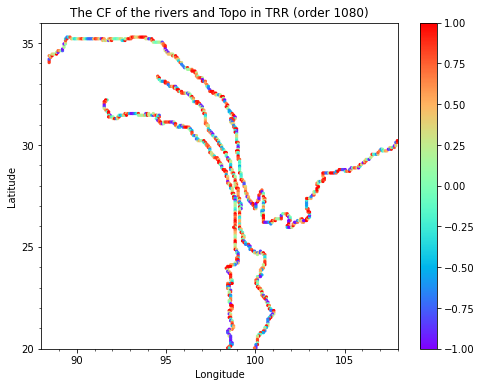

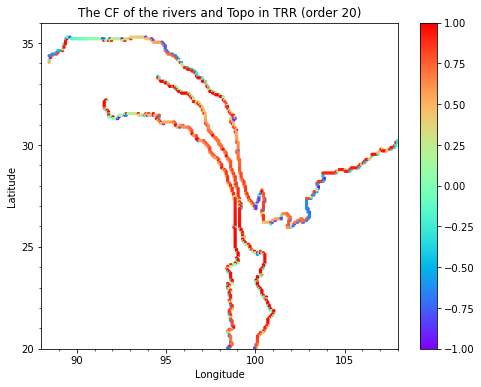

In [9]:
for i in range(0,len(order_tRange)):
    # filter by processing SHCs
    order_t = order_tRange[i]
    lmax = int(order_t+1)
    coeffs_f = coeffs.copy()
    coeffs_f[:, lmax:, :] = 0.
    topo_f = pysh.expand.MakeGridDH(coeffs_f, sampling=2)
    
    # get the area
    extent_area_r,data_areaf = fnqx.get_data(topo_f,extent_area,res_deg)

    # plot parameters
    data_img = data_areaf.copy()
    order_img = order_t
    fname_fig = 'The CF of the rivers and Topo in ' + name_area +' (order ' + str(order_img) + ')'
    
    # gradient of the area topo 
    UY,UX = np.gradient(-np.flipud(data_img.copy()))

    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(111)
    ax.set(xlabel='Longitude', ylabel='Latitude', yticks=yticks, xticks=xticks)
    ax.minorticks_on()
    ax.axis(extent_fig)
    ax.set_title(fname_fig)
    for i_river in range(0,len(labels)):
        # load river data
        fname_load = "../data/data_rivers/River"+labels2[i_river]+'_mesh.txt'
        river_data = np.loadtxt(fname_load)
        river_xy   = river_data[:,0:2]
        river_idxy = river_data[:,2:4]
        azi_river  = river_data[:,4]
     
        # cal the azimuth of the topo
        azi_topo = np.zeros(len(azi_river))
        river_idyx = np.fliplr(river_idxy.copy()).astype(int)
        for ii in range(0,len(azi_river)):
            idyx = tuple(river_idyx[ii])
            x = UX[idyx]
            y = UY[idyx]
            azi_topo[ii] = fnqx.cal_azi(0,0,x,y)
    
        delta = np.abs(azi_river - azi_topo)
        cf = np.cos(np.radians(delta))
        
        sc = ax.scatter(river_xy[:,0],river_xy[:,1],label=labels[i_river],c=cf,vmin=-1,vmax=1,cmap=cm.rainbow,s=5)
    plt.colorbar(sc)
    if save_mode == True:
        plt.savefig((fname_fig+'.png'),dpi=dpi)
    plt.show()